In [3]:
# ==============================
# Import Libraries
# ==============================
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
)
from imblearn.over_sampling import SMOTE
import joblib

In [4]:
# ==============================
# Load Dataset
# ==============================
data = pd.read_csv("Downloads/creditcard.csv")

# Basic overview
print(data.head())
print(data.tail())
print(f"Rows: {data.shape[0]}, Columns: {data.shape[1]}")
print(data.info())
print("Null values:\n", data.isnull().sum())


   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

In [7]:
# ==============================
# Data Preprocessing
# ==============================
# Scale 'Amount'
sc_amount = StandardScaler()
data['Amount'] = sc_amount.fit_transform(pd.DataFrame(data['Amount']))

# Drop 'Time' column
data = data.drop(['Time'], axis=1)

# Remove duplicates
data = data.drop_duplicates()
print("Duplicates removed. New shape:", data.shape)


Duplicates removed. New shape: (275663, 30)


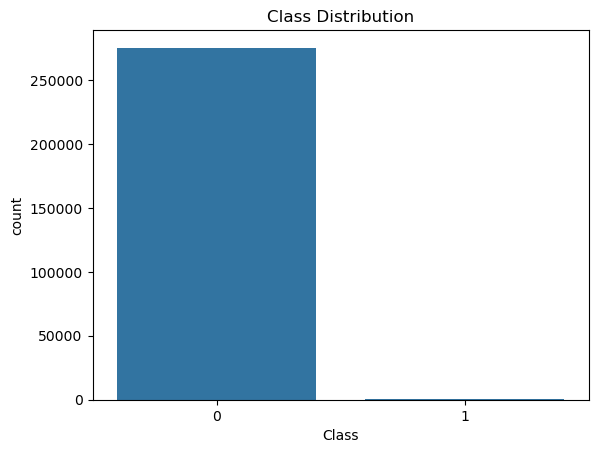

Class distribution:
 Class
0    275190
1       473
Name: count, dtype: int64


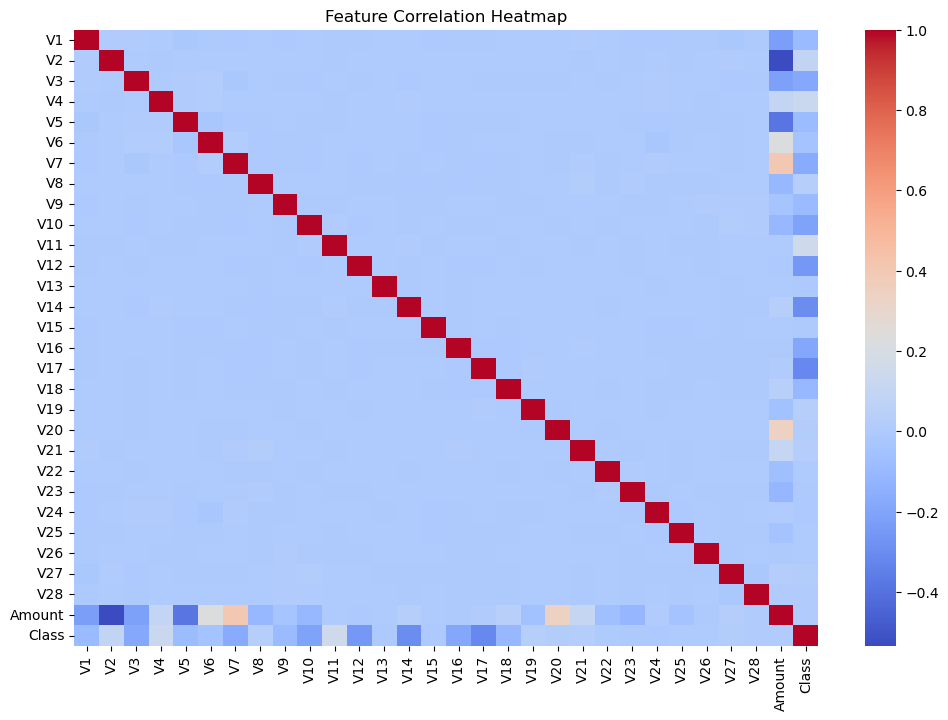

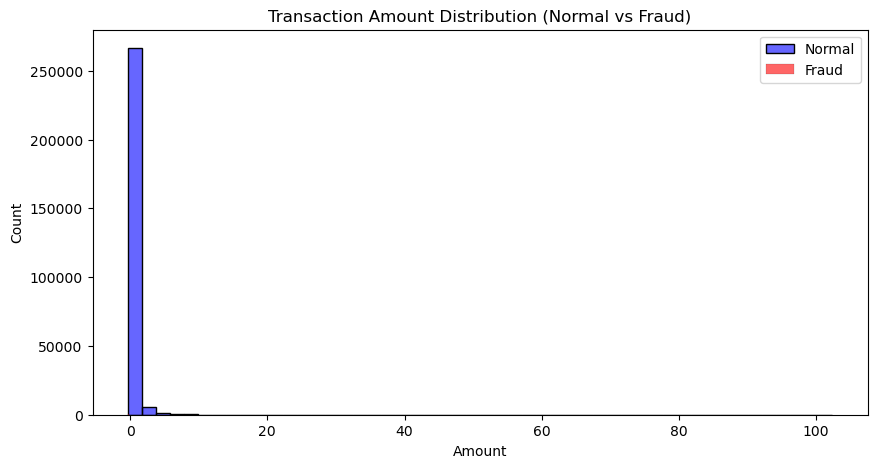

/var/folders/ld/s14kwm9d3fv3h7j7s1m955600000gn/T/ipykernel_12097/3466843364.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Class', y='Amount', data=data, palette="Set2")


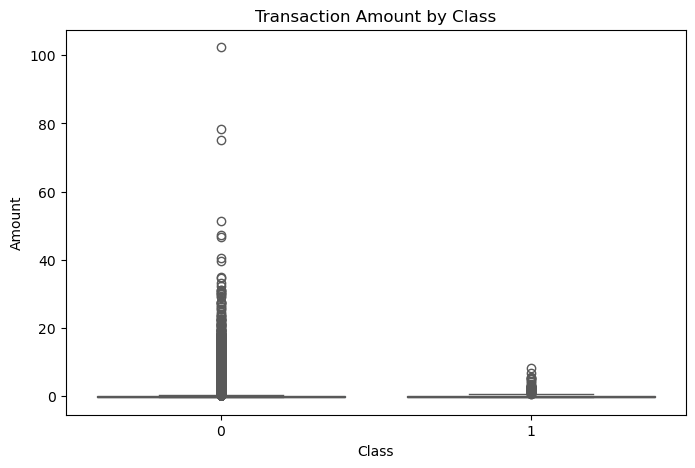

In [9]:
# ==============================
# Exploratory Data Analysis
# ==============================

#  Class Distribution
sns.countplot(x='Class', data=data)
plt.title('Class Distribution')
plt.show()

print("Class distribution:\n", data['Class'].value_counts())

# Correlation Heatmap
plt.figure(figsize=(12,8))
sns.heatmap(data.corr(), cmap="coolwarm", annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()

#  Transaction Amount Distribution
plt.figure(figsize=(10,5))
sns.histplot(data[data['Class']==0]['Amount'], bins=50, color="blue", label="Normal", alpha=0.6)
sns.histplot(data[data['Class']==1]['Amount'], bins=50, color="red", label="Fraud", alpha=0.6)
plt.legend()
plt.title("Transaction Amount Distribution (Normal vs Fraud)")
plt.show()

#  Boxplot of Amount by Class
plt.figure(figsize=(8,5))
sns.boxplot(x='Class', y='Amount', data=data, palette="Set2")
plt.title("Transaction Amount by Class")
plt.show()


In [11]:
# ==============================
# Train/Test Split
# ==============================
X = data.drop(columns=['Class'])
y = data['Class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [13]:
# ==============================
#  Handle Class Imbalance
# ==============================
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

print(f"Before SMOTE, label '1': {sum(y_train==1)}")
print(f"After SMOTE, label '1': {sum(y_train_res==1)}")


Before SMOTE, label '1': 378
After SMOTE, label '1': 220152


In [15]:
# ==============================
# Define Models
# ==============================
models = {
    "Logistic Regression": LogisticRegression(solver='lbfgs', max_iter=5000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Support Vector Machine": SVC(kernel='rbf', probability=True, random_state=42)
}


In [ ]:
# ==============================
# Train and Evaluate Models
# ==============================
def train_evaluate(model_name, model, X_tr, X_te, y_tr, y_te, scale=False):
    if scale:
        scaler = StandardScaler()
        X_tr = scaler.fit_transform(X_tr)
        X_te = scaler.transform(X_te)
    
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)
    
    print(f"\n==== {model_name} ====")
    print("Accuracy:", accuracy_score(y_te, y_pred))
    print("F1 Score:", f1_score(y_te, y_pred))
    print("Precision:", precision_score(y_te, y_pred))
    print("Recall:", recall_score(y_te, y_pred))
    print("\nClassification Report:\n", classification_report(y_te, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_te, y_pred))


# Loop through models
slow_models = ["K-Nearest Neighbors", "Support Vector Machine"]  # optionally skip or run later

for name, model in models.items():
    if name in ["Logistic Regression", "K-Nearest Neighbors", "Support Vector Machine"]:
        # Use oversampled data and scale
        train_evaluate(name, model, X_train_res, X_test_scaled, y_train_res, y_test, scale=False)
    else:
        # Use original data without scaling
        train_evaluate(name, model, X_train, X_test, y_train, y_test)



==== Logistic Regression ====
Accuracy: 0.9742259626720838
F1 Score: 0.10685103708359522
Precision: 0.056818181818181816
Recall: 0.8947368421052632

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99     55038
           1       0.06      0.89      0.11        95

    accuracy                           0.97     55133
   macro avg       0.53      0.93      0.55     55133
weighted avg       1.00      0.97      0.99     55133

Confusion Matrix:
 [[53627  1411]
 [   10    85]]

==== Decision Tree ====
Accuracy: 0.9990749641775343
F1 Score: 0.7182320441988951
Precision: 0.7558139534883721
Recall: 0.6842105263157895

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     55038
           1       0.76      0.68      0.72        95

    accuracy                           1.00     55133
   macro avg       0.88      0.84      0.86     55133
weighted avg

In [17]:
# ==============================
# Undersampling Example
# ==============================
normal = data[data['Class'] == 0]
fraud = data[data['Class'] == 1]
normal_under = normal.sample(len(fraud), random_state=42)
new_data = pd.concat([normal_under, fraud], ignore_index=True)

X = new_data.drop('Class', axis=1)
y = new_data['Class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models_under = {
    "Logistic Regression": (LogisticRegression(max_iter=5000, random_state=42), X_train_scaled, X_test_scaled),
    "Decision Tree": (DecisionTreeClassifier(random_state=42), X_train, X_test),
    "Random Forest": (RandomForestClassifier(n_estimators=100, random_state=42), X_train, X_test)
}

for name, (model, X_tr, X_te) in models_under.items():
    model.fit(X_tr, y_train)
    y_pred = model.predict(X_te)
    print(f"\n=== {name} ===")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))



=== Logistic Regression ===
Accuracy: 0.9507042253521126
Confusion Matrix:
 [[140   2]
 [ 12 130]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.99      0.95       142
           1       0.98      0.92      0.95       142

    accuracy                           0.95       284
   macro avg       0.95      0.95      0.95       284
weighted avg       0.95      0.95      0.95       284


=== Decision Tree ===
Accuracy: 0.8873239436619719
Confusion Matrix:
 [[125  17]
 [ 15 127]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.88      0.89       142
           1       0.88      0.89      0.89       142

    accuracy                           0.89       284
   macro avg       0.89      0.89      0.89       284
weighted avg       0.89      0.89      0.89       284


=== Random Forest ===
Accuracy: 0.9507042253521126
Confusion Matrix:
 [[141   1]
 [ 13 129]]
Classifica

In [19]:
# ==============================
# Oversampling with SMOTE
# ==============================
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)
print("Class distribution after oversampling:\n", y_res.value_counts())

X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.3, random_state=42, stratify=y_res
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models_full = {
    "Logistic Regression": (LogisticRegression(max_iter=5000, random_state=42), X_train_scaled, X_test_scaled),
    "Decision Tree": (DecisionTreeClassifier(random_state=42), X_train, X_test),
    "Random Forest": (RandomForestClassifier(n_estimators=100, random_state=42), X_train, X_test),
    "K-Nearest Neighbors": (KNeighborsClassifier(n_neighbors=5), X_train_scaled, X_test_scaled),
    "Support Vector Machine": (SVC(kernel='rbf', random_state=42, probability=True), X_train_scaled, X_test_scaled)
}

for name, (model, X_tr, X_te) in models_full.items():
    model.fit(X_tr, y_train)
    y_pred = model.predict(X_te)
    print(f"\n=== {name} ===")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))


Class distribution after oversampling:
 Class
0    473
1    473
Name: count, dtype: int64

=== Logistic Regression ===
Accuracy: 0.9507042253521126
Confusion Matrix:
 [[140   2]
 [ 12 130]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.99      0.95       142
           1       0.98      0.92      0.95       142

    accuracy                           0.95       284
   macro avg       0.95      0.95      0.95       284
weighted avg       0.95      0.95      0.95       284


=== Decision Tree ===
Accuracy: 0.8873239436619719
Confusion Matrix:
 [[125  17]
 [ 15 127]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.88      0.89       142
           1       0.88      0.89      0.89       142

    accuracy                           0.89       284
   macro avg       0.89      0.89      0.89       284
weighted avg       0.89      0.89      0.89       284


=== Random Fo

In [23]:
print(X.shape)  # Should show (num_samples, 30)
print(len(X.columns))  # Should print 30


(946, 29)
29


In [25]:
# ==============================
# Save & Load Model
# ==============================
dtc = DecisionTreeClassifier()
dtc.fit(X_res, y_res)
joblib.dump(dtc, "credit_card_model.pkl")

# Load and predict
model = joblib.load("credit_card_model.pkl")

sample_input = [[
    1.19185711131486, 0.26615071205963, 0.16648011335321, 0.448154078460911,
    0.0600176492822243, -0.0823608088155687, -0.0788029833323113,
    0.0851016549148104, -0.255425128109186, -0.166974414004614,
    1.61272666105479, 1.06523531137287, 0.48909501589608, -0.143772296441519,
    0.635558093258208, 0.463917041022171, -0.114804663102346,
    -0.183361270123994, -0.145783041325259, -0.0690831352230203,
    -0.225775248033138, -0.638671952771851, 0.101288021253234,
    -0.339846475529127, 0.167170404418143, 0.125894532368176,
    -0.00898309914322813, 0.0147241691924927, 2.69  # now 29 values
]]

sample_input_df = pd.DataFrame(sample_input, columns=X.columns)
pred = model.predict(sample_input_df)
print("Normal transaction" if pred[0] == 0 else "Fraud transaction")


Normal transaction


In [29]:
# ==============================
# Prepare Model Inputs for Visualization
# ==============================
model_inputs = {
    "Logistic Regression": (X_train_res, X_test_scaled, y_train_res, y_test),
    "Decision Tree": (X_train, X_test, y_train, y_test),
    "Random Forest": (X_train, X_test, y_train, y_test),
    "K-Nearest Neighbors": (X_train_scaled, X_test_scaled, y_train, y_test),
    "Support Vector Machine": (X_train_scaled, X_test_scaled, y_train, y_test)
}

# Use models_full dictionary for trained models
models = {name:model for name,(model,_,_) in models_full.items()}


In [35]:
# ==============================
#Save All Visuals (High DPI & Transparent)
# ==============================
import os

# Create directories
os.makedirs("plots_hd/class_distribution", exist_ok=True)
os.makedirs("plots_hd/correlation_heatmap", exist_ok=True)
os.makedirs("plots_hd/amount_distribution", exist_ok=True)
os.makedirs("plots_hd/confusion_matrices", exist_ok=True)
os.makedirs("plots_hd/roc_curves", exist_ok=True)
os.makedirs("plots_hd/pr_curves", exist_ok=True)
os.makedirs("plots_hd/feature_importance", exist_ok=True)

# Save function
def save_plot(fig, path):
    fig.savefig(path, dpi=300, transparent=True, bbox_inches='tight')
    plt.close(fig)

# Class distribution
fig = plt.figure(figsize=(6,4))
sns.countplot(x='Class', data=data)
plt.title('Class Distribution')
save_plot(fig, "plots_hd/class_distribution/class_distribution.png")

# Correlation heatmap
fig = plt.figure(figsize=(12,8))
sns.heatmap(data.corr(), cmap="coolwarm", annot=False)
plt.title("Feature Correlation Heatmap")
save_plot(fig, "plots_hd/correlation_heatmap/correlation_heatmap.png")

# Amount distribution
fig = plt.figure(figsize=(10,5))
sns.histplot(data[data['Class']==0]['Amount'], bins=50, color="blue", label="Normal", alpha=0.6)
sns.histplot(data[data['Class']==1]['Amount'], bins=50, color="red", label="Fraud", alpha=0.6)
plt.legend()
plt.title("Transaction Amount Distribution")
save_plot(fig, "plots_hd/amount_distribution/amount_distribution.png")

fig = plt.figure(figsize=(8,5))
# explicitly set hue to remove warning
ax = sns.boxplot(x='Class', y='Amount', hue='Class', data=data, palette="Set2", dodge=False)
ax.get_legend().remove()  # remove extra legend

plt.title("Transaction Amount by Class")
save_plot(fig, "plots_hd/amount_distribution/amount_boxplot.png")

# Confusion matrices, ROC, PR curves
for name, (X_tr, X_te, y_tr, y_te) in model_inputs.items():
    model = models[name]
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)
    
    # Confusion matrix
    fig = plt.figure(figsize=(6,5))
    sns.heatmap(confusion_matrix(y_te, y_pred), annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    save_plot(fig, f"plots_hd/confusion_matrices/{name}_CM.png")
    
    # ROC curve
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_te)[:,1]
    else:
        y_prob = model.decision_function(X_te)
    fpr, tpr, _ = roc_curve(y_te, y_prob)
    roc_auc = auc(fpr, tpr)
    fig = plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})', color='blue')
    plt.plot([0,1],[0,1],'--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name}')
    plt.legend()
    save_plot(fig, f"plots_hd/roc_curves/{name}_ROC.png")
    
    # Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_te, y_prob)
    fig = plt.figure(figsize=(8,6))
    plt.plot(recall, precision, label=name, color='green')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {name}')
    plt.legend()
    save_plot(fig, f"plots_hd/pr_curves/{name}_PR.png")

# Random Forest feature importance
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
importances = pd.Series(rf.feature_importances_, index=X.columns)
fig = plt.figure(figsize=(8,5))
importances.nlargest(10).plot(kind='barh')
plt.title("Top 10 Important Features - Random Forest")
save_plot(fig, "plots_hd/feature_importance/feature_importance.png")

print("All high-resolution, transparent plots saved in 'plots_hd/' folder.")


All high-resolution, transparent plots saved in 'plots_hd/' folder.
